# <span style="color:#1F618D">CASCADe-filtering</span> for MIRI LRS data with a low Cosmic Hit Rate #

This notebook shows the basic functions of the <span style="color:#1F618D">CASCADe-filtering</span> module when using it on a set of simulated spectral images for MIRI LRS with a low cosmic hit rate. Simulated are a series of 10 integrations on a bright solar type star with the LRS in slitles prism mode. The <span style="color:#1F618D">CASCADe-filtering</span> package, a side package of the <span style="color:#1F618D">CASCADe</span> transit spectroscopy package, is developed to identify 'bad' pixels in a spectral image cube, especially those obtained with transit observations. The package can identify bad pixels and create a cleaned version of the data together with a fitered (smoothed) version of the data cube. The filtering was designed such, that it is edge preserving, meaning that the filtered data has the same spatial spectral profile as the input data. This means it can be used to create an extraction weight for optimal spectral extraction, which we will also demonstrate in this notebook.

The filtering applied in this package is similar to that implemented by Nagano & Matsuyama and Kuwahara. Using a stack of anisotropic filter kernels, for each data pixel an optimal filter kernel is selected such that the optimal filter has the lowest variance. 

To run this example we first we import the relevant modules.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pathlib
import os

from cascade_filtering.filtering import DirectionalFilter
from cascade_filtering.kernel import FilterKernel

from  cascade_filtering.utilities import create_mask_from_dq
from  cascade_filtering.utilities import find

from cascade_filtering.initialize import CASCADE_FILTERING_EXAMPLE_DIR

%matplotlib inline

we then define the paths to the filter kernel configuration files and the simulated data  

In [2]:
CONFIG_PATH = pathlib.Path(CASCADE_FILTERING_EXAMPLE_DIR) / 'config_files/'

ILLUMINATION_MODEL_PATH = pathlib.Path(CASCADE_FILTERING_EXAMPLE_DIR) / 'data/MIRI/LRS/illumination_model'
DATA_PATH = pathlib.Path(CASCADE_FILTERING_EXAMPLE_DIR) / 'data/MIRI/LRS/low_rate/'
DATA_PATH_NO_COSMICS = pathlib.Path(CASCADE_FILTERING_EXAMPLE_DIR) / 'data/MIRI/LRS/no_cosmics/'


We then load the simulated data with low cosmic hit rate, and as reference a data set with no cosmic hits and the input illumination model.

In [3]:
files = find('*_rateints.fits', DATA_PATH)
image_file = pathlib.Path(files[0])
with fits.open(image_file) as hdul:
    print(hdul.info())
    spectral_image_cube = hdul['SCI'].data
    spectral_image_uncertainty = hdul['ERR'].data
    spectral_image_mask = hdul['DQ'].data
spectral_image_cube = spectral_image_cube.astype(float)
spectral_image_uncertainty = spectral_image_uncertainty.astype(float)
spectral_image_mask = create_mask_from_dq(spectral_image_mask.astype(int))  

Filename: /home/bouwman/CASCADeSTORAGE/examples_filtering/data/MIRI/LRS/low_rate/det_image_with_low_cosmics_rateints.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     130   ()      
  1  SCI           1 ImageHDU        47   (72, 416, 10)   float32   
  2  ERR           1 ImageHDU        11   (72, 416, 10)   float32   
  3  DQ            1 ImageHDU        12   (72, 416, 10)   int32 (rescales to uint32)   
  4  INT_TIMES     1 BinTableHDU     24   0R x 7C   [J, D, D, D, D, D, D]   
  5  VAR_POISSON    1 ImageHDU        10   (72, 416, 10)   float32   
  6  VAR_RNOISE    1 ImageHDU        10   (72, 416, 10)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [4214B]   
None


In [4]:
files = find('*_rateints.fits', DATA_PATH_NO_COSMICS)
image_file = pathlib.Path(files[0])
with fits.open(image_file) as hdul:
    spectral_image_cube_noc = hdul['SCI'].data
    spectral_image_uncertainty_noc = hdul['ERR'].data
    spectral_image_mask_noc = hdul['DQ'].data
spectral_image_cube_noc = spectral_image_cube_noc.astype(float)
spectral_image_uncertainty_noc = spectral_image_uncertainty_noc.astype(float)
spectral_image_mask_noc = create_mask_from_dq(spectral_image_mask_noc.astype(int))  

In [5]:
files = find('*.fits', ILLUMINATION_MODEL_PATH)
image_file = pathlib.Path(files[0])
with fits.open(image_file) as hdul:
    print(hdul.info())
    illumination_model_image = hdul['INTENSITY'].data
    illumination_model_wavelength = hdul['WAVELENGTH'].data
illumination_model_image = illumination_model_image.astype(float)
illumination_model_wavelength = illumination_model_wavelength.astype(float)

detector_gain = 5.6
illumination_model_image /= detector_gain

Filename: /home/bouwman/CASCADeSTORAGE/examples_filtering/data/MIRI/LRS/illumination_model/illum_model_seq1_MIRIMAGE_P750L.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      39   ()      
  1  INTENSITY     1 ImageHDU        45   (72, 416)   float32   
  2  WAVELENGTH    1 ImageHDU        13   (72, 416)   float32   
  3  ASDF          1 BinTableHDU     11   1R x 1C   [1898B]   
None


We also create a empty bad pixel mask and define the region of interest in the slitles sub array which cuts away parts of the detector data which hold no data of interest to save memory and to spead things up.

In [6]:
spectral_image_mask_blank = np.zeros_like(spectral_image_mask, dtype=bool)

ROI = np.zeros_like(spectral_image_cube[0,...], dtype=bool)
# flag 8 pixels to the left and right of thr subarray
ROI[:, :9] = True
ROI[:, 68:] = True
# flag the top and bottowm parts of the sub array
ROI[:100, :] =True
ROI[-20:, :] =True

The row-summed spectra of the input model and the two referecne models look like this:

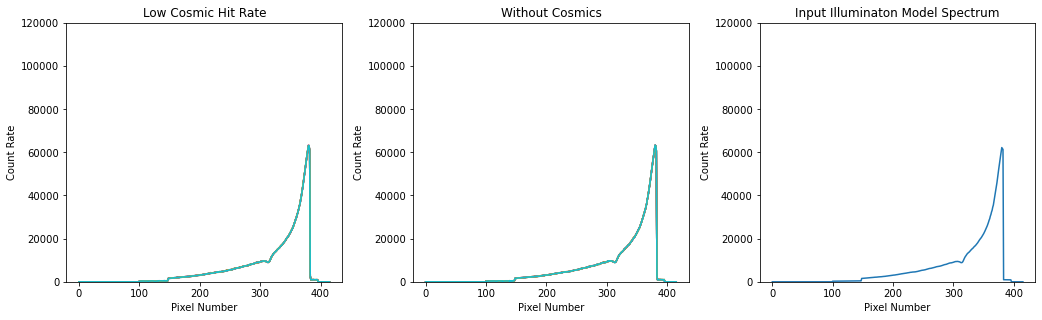

In [7]:
spectra_with_cosmics = np.sum(spectral_image_cube*(~ROI).astype(int), axis=2)
spectra_without_cosmics = np.sum(spectral_image_cube_noc*(~ROI).astype(int), axis=2)
input_spectrum = np.sum(illumination_model_image*(~ROI).astype(int), axis=1)

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.tight_layout(pad=4.0)
ax[0].plot(spectra_with_cosmics.T)
ax[0].set_title('Low Cosmic Hit Rate')
ax[0].set_ylim([0, 1.2e5])
ax[0].set_ylabel('Count Rate')
ax[0].set_xlabel('Pixel Number')
ax[1].plot(spectra_without_cosmics.T)
ax[1].set_title('Without Cosmics')
ax[1].set_ylim([0, 1.2e5])
ax[1].set_ylabel('Count Rate')
ax[1].set_xlabel('Pixel Number')
ax[2].plot(input_spectrum)
ax[2].set_title('Input Illuminaton Model Spectrum')
ax[2].set_ylim([0, 1.2e5])
ax[2].set_ylabel('Count Rate')
ax[2].set_xlabel('Pixel Number')
plt.show()

And a zoom on a part of the spectral trace for the three models looks like this:

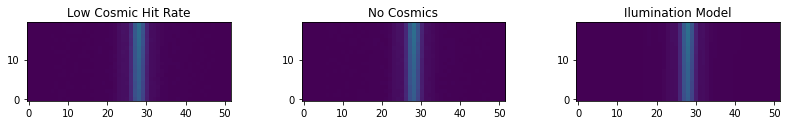

In [8]:
zoom_with_cosmics = spectral_image_cube[0, 270:290, 10:-10]
zoom_without_cosmics = spectral_image_cube_noc[0, 270:290, 10:-10]
zoom_ilumination_model = illumination_model_image[270:290, 10:-10]
fig, ax = plt.subplots(1,3, figsize=(12,5))
fig.tight_layout(pad=4.0)
ax[0].imshow(zoom_with_cosmics, interpolation=None, origin='lower', vmin=10, vmax=5000)
ax[0].set_title('Low Cosmic Hit Rate')
ax[1].imshow(zoom_without_cosmics, interpolation=None, origin='lower', vmin=10, vmax=5000)
ax[1].set_title('No Cosmics')
ax[2].imshow(zoom_ilumination_model, interpolation=None, origin='lower', vmin=10, vmax=5000)
ax[2].set_title('Ilumination Model')
plt.show()

wich shows that for a low cosmic rate setting with the MIRI simulator, the spectral images effectively show no cosmic hits. We use this dataset to demonstrate the filtering and to show that there are no side effect to the filtering, such as incorrect changes to the spectral shape and mis identification of bad pixels.

## Using a 2D anisotropic filter ##

As a first usage example we load the standard filter kernel set of CASCADe, also used for Spitzer and HST data. This a set of 2D filters, consisting of in the dispersion direction elonggated gaussian kernels, and a few 'banana' shaped kernels to capture the shape of the end points of the spectral trace. Note that as this filter is 2D, not filtering in the time domain is applied. To load the kernel stack, one issues the following commands:

In [9]:
FK = FilterKernel(configuration_file='banana_kernel.conf', path=CONFIG_PATH)
KERNEL_STACK = FK.kernel_stack

We can now print some basic information and plot a few of the kernels.

Kernel configuration parameters: {'kernel_name': 'banana', 'kernel_shape': (9, 9)}
Kernel stack shape: (18, 9, 9)


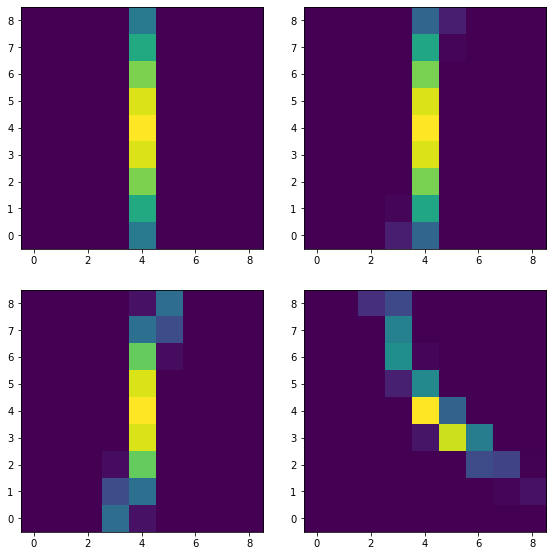

In [10]:
print(f"Kernel configuration parameters: {FK.configuration}")
print(f"Kernel stack shape: {KERNEL_STACK.shape}")

fig, ax = plt.subplots(2,2, figsize=(8,8))
fig.tight_layout(pad=1.0)
ax[0, 0].imshow(KERNEL_STACK[2,...], interpolation=None, origin='lower')
ax[0, 1].imshow(KERNEL_STACK[7,...], interpolation=None, origin='lower')
ax[1, 0].imshow(KERNEL_STACK[9,...], interpolation=None, origin='lower')
ax[1, 1].imshow(KERNEL_STACK[14,...], interpolation=None, origin='lower')
plt.show()

We now create a filter object, load the kernel stack and apply the filtering on the data. For this we use the empty pixel mask, i.e. we assume no prior knowledge on bad pixels. We also apply the region of interest mask.

In [11]:
DF = DirectionalFilter(sigma=4.0, max_iterations=39, acceptance_treshold=0.0001)
DF.load_filter_kernels(KERNEL_STACK)
DF.run_filter(spectral_image_cube, spectral_image_mask_blank, spectral_image_uncertainty, ROI=ROI)

iteration: 1, number of flagged pixel: 0
iteration: 2, number of flagged pixel: 2508
iteration: 3, number of flagged pixel: 765
iteration: 4, number of flagged pixel: 251
iteration: 5, number of flagged pixel: 84
iteration: 6, number of flagged pixel: 29
Final number of still flagged pixel after iterations: 11
The acceptance limit is: 17


After a few iterations the filtering converges.Note that we used the blank bad pixel mask. We can also used the pixel mask coming with this data. In case of permanetly flagged bad pixels or pixels flagged in other pipeline steps like saturation flagging, we can use these as an initial input to the filtering. This could potentially speed things up as the filtering can imidiate ignore these pixels from the start of the iteration. The make use of the predefined bad pixel mask, run the filtering in the following way:

In [12]:
DF = DirectionalFilter(sigma=4.0, max_iterations=39, acceptance_treshold=0.0001)
DF.load_filter_kernels(KERNEL_STACK)
DF.run_filter(spectral_image_cube, spectral_image_mask, spectral_image_uncertainty, ROI=ROI)

iteration: 1, number of flagged pixel: 100
iteration: 2, number of flagged pixel: 2527
iteration: 3, number of flagged pixel: 775
iteration: 4, number of flagged pixel: 248
iteration: 5, number of flagged pixel: 88
iteration: 6, number of flagged pixel: 30
Final number of still flagged pixel after iterations: 11
The acceptance limit is: 17


After the same number iterations the filtering converges, which is not surprizing as the number of initially flaged pixels is only 100 in the entire data set. We can now look at the results. We will first make an comparison between one of the input images and the corresponding cleaned image. The updated bad pixel mask, cleaned data set and the optimally filtered (smoothed) dataset can be returned from the filter object as follows

In [13]:
new_bad_pixel_mask = DF.return_updated_mask()
cleaned_image_cube, cleaned_image_cube_uncertainty, cleaned_image_cube_mask = DF.return_cleaned_data()
filtered_image_cube, filtered_image_cube_uncertainty, filtered_image_cube_mask = DF.return_filtered_data()

The optimal filter number for each pixel and the valid data region as limited by the ROI can be retrieved as follows:

In [14]:
optimal_filter_kernel_number = DF.index_optimal_filter_kernel[0][DF.pp_data_cube_valid_index]
valid_region_data = DF.pp_roi_image_cube_index

Plotting the comparison between the input data and cleaned data

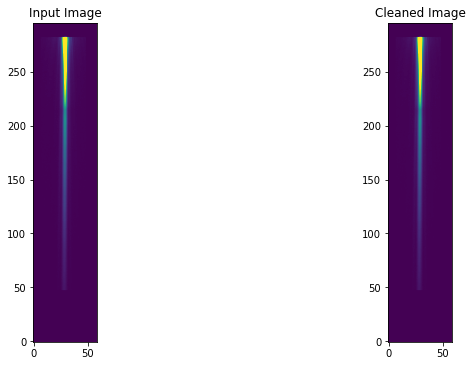

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(pad=1.0)
ax[0].imshow(spectral_image_cube[valid_region_data][0,...], interpolation=None, origin='lower', vmin=10, vmax=4000)
ax[0].set_title('Input Image')
ax[1].imshow(cleaned_image_cube[valid_region_data][0, ...], interpolation=None, origin='lower', vmin=10, vmax=4000)
ax[1].set_title('Cleaned Image')
plt.show()

shows no large differences as expected, as there should be no major cosmic hit in the input data set. We can also have a look at some of the other output, such as the new bad pixel mask in comparison to the original data mask, the optimal filter kernel for each detector pixel and the filtered data. Looking at the optimal filter kernel index, one can clearly see that optimal filter kernels follow the the spectral trace of the dispersed stellar light.

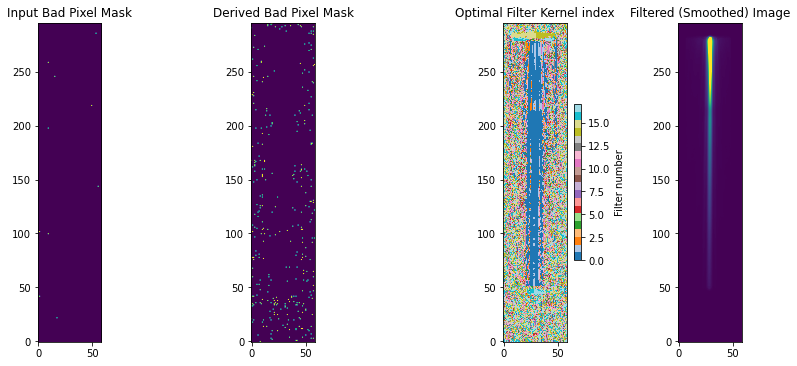

In [16]:
fig, ax = plt.subplots(1,4, figsize=(12,5))
fig.tight_layout(pad=1.0)
ax[0].imshow(spectral_image_mask[valid_region_data][0,...], interpolation=None, origin='lower')
ax[0].set_title('Input Bad Pixel Mask')
ax[1].imshow(new_bad_pixel_mask[valid_region_data][0,...], interpolation=None, origin='lower')
ax[1].set_title('Derived Bad Pixel Mask')
p = ax[2].imshow(optimal_filter_kernel_number[0, ...], interpolation=None, origin='lower', cmap='tab20')
ax[2].set_title('Optimal Filter Kernel index')
fig.colorbar(p, ax=ax[2], fraction=0.046, pad=0.04).set_label("Filter number")
ax[3].imshow(filtered_image_cube[valid_region_data][0,...], interpolation=None, origin='lower', vmin=10, vmax=4000)
ax[3].set_title('Filtered (Smoothed) Image')
plt.show()

We can also have a look at the filtered spectral data images and the derived spatial profile in comparison to the input data and the used ilumination model. This comparison shows that the cleaned data is consistend with the data without cosmic hits and that the filtered (smoothed) data recovers the input illumination model.

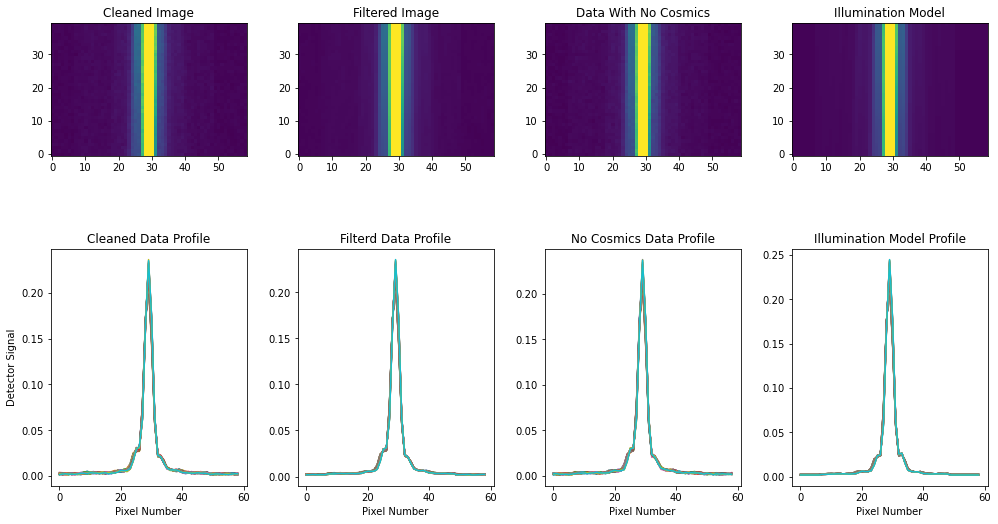

In [17]:
zoom_cleaned_data = cleaned_image_cube[valid_region_data][0, 170:210, :]
zoom_filtered_data = filtered_image_cube[valid_region_data][0, 170:210, :]
zoom_without_cosmics = spectral_image_cube_noc[valid_region_data][0, 170:210, :]
zoom_illuminaton_model = illumination_model_image[valid_region_data[1:]][0, 170:210, :]

fig, ax = plt.subplots(2,4, figsize=(14,8))
fig.tight_layout(pad=2.0)
ax[0,0].imshow(zoom_cleaned_data, interpolation=None, origin='lower', vmin=10, vmax=800)
ax[0,0].set_title('Cleaned Image')
ax[0,1].imshow(zoom_filtered_data, interpolation=None, origin='lower', vmin=10, vmax=800)
ax[0,1].set_title('Filtered Image')
ax[0,2].imshow(zoom_without_cosmics, interpolation=None, origin='lower', vmin=10, vmax=800)
ax[0,2].set_title('Data With No Cosmics')
ax[0,3].imshow(zoom_illuminaton_model, interpolation=None, origin='lower', vmin=10, vmax=800)
ax[0,3].set_title('Illumination Model')
ax[1,0].plot((zoom_cleaned_data/np.sum(zoom_cleaned_data, axis=1, keepdims=True)).T)
ax[1,0].set_title('Cleaned Data Profile')
ax[1,0].set_xlabel('Pixel Number')
ax[1,0].set_ylabel('Detector Signal')
ax[1,1].plot((zoom_filtered_data/np.sum(zoom_filtered_data, axis=1, keepdims=True)).T)
ax[1,1].set_title('Filterd Data Profile')
ax[1,1].set_xlabel('Pixel Number')
ax[1,2].plot((zoom_without_cosmics/np.sum(zoom_without_cosmics, axis=1, keepdims=True)).T)
ax[1,2].set_title('No Cosmics Data Profile')
ax[1,2].set_xlabel('Pixel Number')
ax[1,3].plot((zoom_illuminaton_model/np.sum(zoom_illuminaton_model, axis=1, keepdims=True)).T)
ax[1,3].set_title('Illumination Model Profile')
ax[1,3].set_xlabel('Pixel Number')
plt.show()

Finally, we show how to use the filtered (smoothed) data as an extraction weight to get an optimal extracted spectrum. As one now has an extraction weight based in the data itself, the spectral extraction becomes independent of pointing movements and psf changes during a long time series observation. 

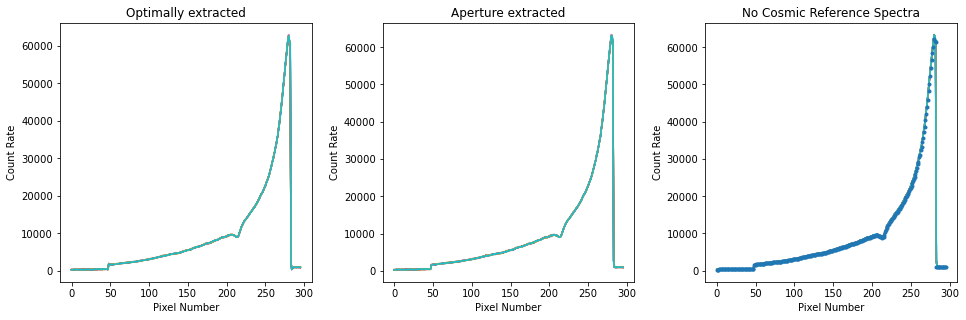

In [18]:
data_with_no_cosmics = spectral_image_cube_noc[valid_region_data]
data_illuminaton_model = illumination_model_image[valid_region_data[1:]]

data = spectral_image_cube[valid_region_data]
error = spectral_image_uncertainty[valid_region_data]
mask = new_bad_pixel_mask[valid_region_data]

cleaned_data = cleaned_image_cube[valid_region_data]
cleaned_data_error = cleaned_image_cube_uncertainty[valid_region_data]
cleaned_data_mask = cleaned_image_cube_mask[valid_region_data]

extraction_profile = filtered_image_cube[valid_region_data]
extraction_profile = extraction_profile/np.sum(extraction_profile, axis=2, keepdims=True)

optimally_extracted_spectra = \
    (np.ma.sum(~mask*extraction_profile*data*error**-2, axis=2) /
     np.ma.sum((~mask*extraction_profile/error)**2, axis=2))

aperture_extracted_spectrum = np.sum(cleaned_data * ~cleaned_data_mask, axis=2)

spectrum_with_no_cosmics = np.sum(data_with_no_cosmics, axis=2)
spectrum_illumination_model = np.sum(data_illuminaton_model[0, ...], axis=1)

fig, ax = plt.subplots(1,3, figsize=(14,5))
fig.tight_layout(pad=4.0)
ax[0].plot(optimally_extracted_spectra.T)
ax[0].set_title('Optimally extracted')
ax[0].set_ylabel('Count Rate')
ax[0].set_xlabel('Pixel Number')
ax[1].plot(aperture_extracted_spectrum.T)
ax[1].set_title('Aperture extracted')
ax[1].set_ylabel('Count Rate')
ax[1].set_xlabel('Pixel Number')
ax[2].plot(spectrum_with_no_cosmics.T)
ax[2].plot(spectrum_illumination_model,'.', lw=2)
ax[2].set_title('No Cosmic Reference Spectra')
ax[2].set_ylabel('Count Rate')
ax[2].set_xlabel('Pixel Number')
plt.show()

This concludes the basic use of the CASCADe-filtering package. In the following we will demonstate the use of a different filter kernel which will allow for simultaneous filtering in the spatial, wavelength and time domain.

## Using a 3D anisotropic filter ##

In the previous example we only used afilter kernel operating in the dispersion - cross-dispersion plain. As cosmic hits are transient, inprinciple they should be easely identified along the time (integration number) axis. However, as transit observations are measuring a time variable signal, the source can move on the detector and there might be time variable responce changes, filtering in the time direction is a non trivial excercice as one might end up removing actual signals. Here we introduce a 3d anisotropic gaussian filter kernel, extending the kernel introduced previously into the time domain. By varying the gaussian sigma along the time axis, one can controll the correlation length in the time direction. The kernel stack can be created in a similar way by creating a filter kernel object using the appropriate configuration file: 

In [19]:
FK = FilterKernel(configuration_file='anisotropic_gaussian_kernel.conf', path=CONFIG_PATH)
KERNEL_STACK = FK.kernel_stack

We can now print some basic information and plot 2 of the kernels, displaying the different 2d cross-sections.

Kernel configuration parameters: {'kernel_name': 'anisotropic_gaussian', 'kernel_shape': (9, 9, 9), 'kernel_sigma': {'sigma_time': 2.0, 'sigma_dispersion': 3.0, 'sigma_crossdispersion': 0.2}, 'kernel_rotation_angles': {'theta_min': -12.0, 'theta_max': 12.0, 'ntheta': 25}, 'kernel_add_endpoints': True}
Kernel stack shape: (31, 9, 9, 9)


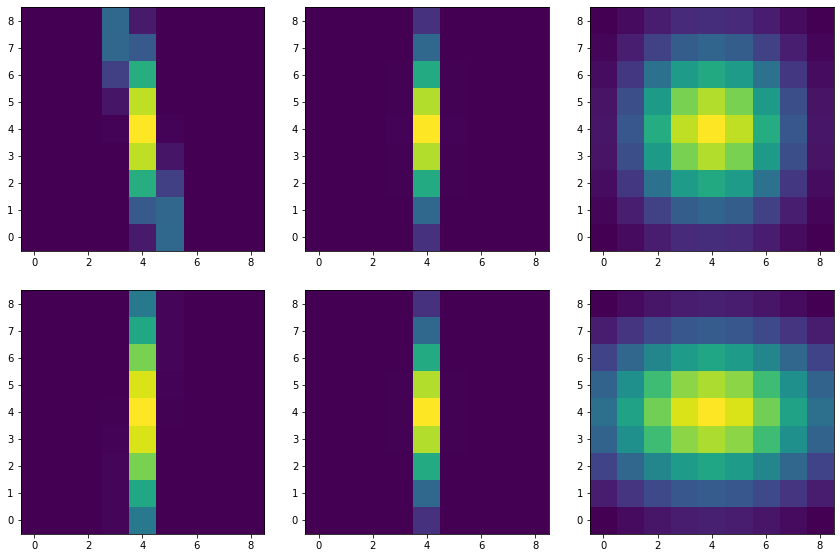

In [20]:
print(f"Kernel configuration parameters: {FK.configuration}")
print(f"Kernel stack shape: {KERNEL_STACK.shape}")

mid_point = KERNEL_STACK.shape[-1]//2

fig, ax = plt.subplots(2,3, figsize=(12,8))
fig.tight_layout(pad=1.0)
ax[0, 0].imshow(KERNEL_STACK[ 2, mid_point, :, :], interpolation=None, origin='lower')
ax[0, 1].imshow(KERNEL_STACK[ 2, :, mid_point, :], interpolation=None, origin='lower')
ax[0, 2].imshow(KERNEL_STACK[ 2, :, :, mid_point], interpolation=None, origin='lower')
ax[1, 0].imshow(KERNEL_STACK[14, mid_point, :, :], interpolation=None, origin='lower')
ax[1, 1].imshow(KERNEL_STACK[14, :, mid_point, :], interpolation=None, origin='lower')
ax[1, 2].imshow(KERNEL_STACK[14, :, :, mid_point], interpolation=None, origin='lower')
plt.show()

We can now created a filter object, load the kernel stack and apply the filtering on the data. For this we use the empty pixel mask, i.e. we assume no prior knowledge on bad pixels. We also apply the region of interest mask. Note that the blank mask in this example can be replaced with the data mask coming with the example data set.

In [21]:
DF = DirectionalFilter(sigma=5.0, max_iterations=39, acceptance_treshold=0.0001)
DF.load_filter_kernels(KERNEL_STACK)
DF.run_filter(spectral_image_cube, spectral_image_mask_blank, spectral_image_uncertainty, ROI=ROI)

iteration: 1, number of flagged pixel: 0
iteration: 2, number of flagged pixel: 3542
iteration: 3, number of flagged pixel: 1834
iteration: 4, number of flagged pixel: 1047
iteration: 5, number of flagged pixel: 683
iteration: 6, number of flagged pixel: 461
iteration: 7, number of flagged pixel: 318
iteration: 8, number of flagged pixel: 205
iteration: 9, number of flagged pixel: 152
iteration: 10, number of flagged pixel: 100
iteration: 11, number of flagged pixel: 61
iteration: 12, number of flagged pixel: 40
iteration: 13, number of flagged pixel: 31
iteration: 14, number of flagged pixel: 29
iteration: 15, number of flagged pixel: 19
Final number of still flagged pixel after iterations: 15
The acceptance limit is: 17


After several iterations the filtering converges again. Note that filtering in 3d takes considerably longer and might require more iterations to converge. Also note that we choose a slightly higher sigma treshold in the filtering of 5.0 as the applied filter can be more aggressive, which is not needed in this low (non) cosmic hit example. We can now look at the results. We will first make an comparison between one of the input images and the corresponding cleaned image. The cleaned and filtered data is:

In [22]:
new_bad_pixel_mask = DF.return_updated_mask()
cleaned_image_cube, cleaned_image_cube_uncertainty, cleaned_image_cube_mask = DF.return_cleaned_data()
filtered_image_cube, filtered_image_cube_uncertainty, filtered_image_cube_mask = DF.return_filtered_data()

The optimal filter number for each pixel and the valid data region as limited by the ROI can be retrieved as follows:

In [23]:
optimal_filter_kernel_number = DF.index_optimal_filter_kernel[0][DF.pp_data_cube_valid_index]
valid_region_data = DF.pp_roi_image_cube_index

Plotting the comparison between the input data and cleaned data

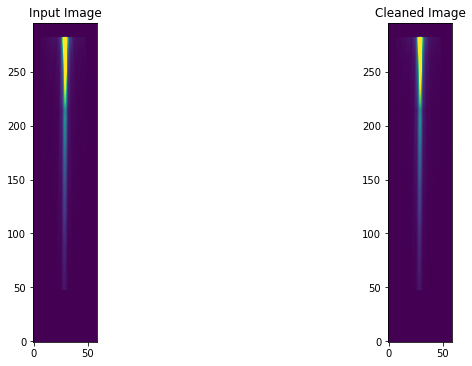

In [24]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
fig.tight_layout(pad=1.0)
ax[0].imshow(spectral_image_cube[valid_region_data][0,...], interpolation=None, origin='lower', vmin=10, vmax=4000)
ax[0].set_title('Input Image')
ax[1].imshow(cleaned_image_cube[valid_region_data][0, ...], interpolation=None, origin='lower', vmin=10, vmax=4000)
ax[1].set_title('Cleaned Image')
plt.show()

Again, the cleaned and input data is very similar as expected. The new bad pixel mask in comparison to the original data mask, the optimal filter kernel for each detector pixel and the fitered data is plotted below. Looking at the optimal filter kernel index, one can clearly see that optimal filter kernels follow the the spectral trace of the dispersed stellar light.

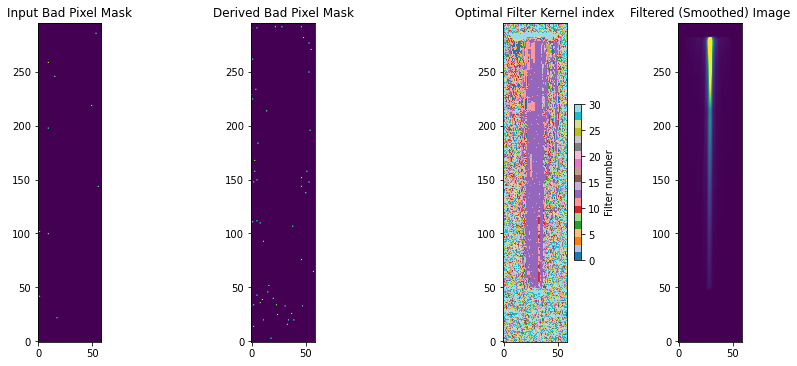

In [25]:
fig, ax = plt.subplots(1,4, figsize=(12,5))
fig.tight_layout(pad=1.0)
ax[0].imshow(spectral_image_mask[valid_region_data][0,...], interpolation=None, origin='lower')
ax[0].set_title('Input Bad Pixel Mask')
ax[1].imshow(new_bad_pixel_mask[valid_region_data][0,...], interpolation=None, origin='lower')
ax[1].set_title('Derived Bad Pixel Mask')
p = ax[2].imshow(optimal_filter_kernel_number[0, ...], interpolation=None, origin='lower', cmap='tab20')
ax[2].set_title('Optimal Filter Kernel index')
fig.colorbar(p, ax=ax[2], fraction=0.046, pad=0.04).set_label("Filter number")
ax[3].imshow(filtered_image_cube[valid_region_data][0,...], interpolation=None, origin='lower', vmin=10, vmax=4000)
ax[3].set_title('Filtered (Smoothed) Image')
plt.show()

We again take a look at the the filtered spectral data images and the derived spatial profile in comparison to the input data and the used ilumination model. As with the previous example, the cleaned data is consistend with the data without cosmic hits and that the filtered (smoothed) data recovers the input illumination model.

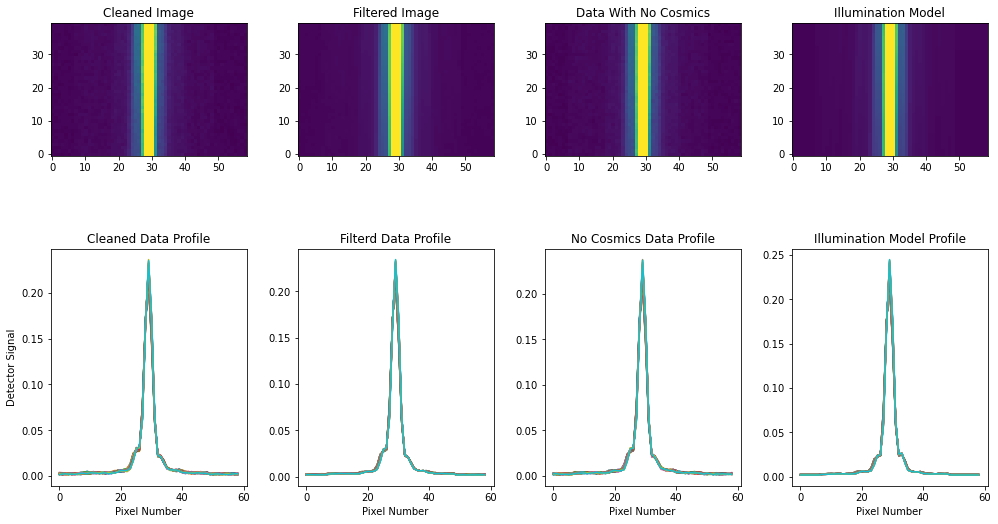

In [26]:
zoom_cleaned_data = cleaned_image_cube[valid_region_data][0, 170:210, :]
zoom_filtered_data = filtered_image_cube[valid_region_data][0, 170:210, :]
zoom_without_cosmics = spectral_image_cube_noc[valid_region_data][0, 170:210, :]
zoom_illuminaton_model = illumination_model_image[valid_region_data[1:]][0, 170:210, :]

fig, ax = plt.subplots(2,4, figsize=(14,8))
fig.tight_layout(pad=2.0)
ax[0,0].imshow(zoom_cleaned_data, interpolation=None, origin='lower', vmin=10, vmax=800)
ax[0,0].set_title('Cleaned Image')
ax[0,1].imshow(zoom_filtered_data, interpolation=None, origin='lower', vmin=10, vmax=800)
ax[0,1].set_title('Filtered Image')
ax[0,2].imshow(zoom_without_cosmics, interpolation=None, origin='lower', vmin=10, vmax=800)
ax[0,2].set_title('Data With No Cosmics')
ax[0,3].imshow(zoom_illuminaton_model, interpolation=None, origin='lower', vmin=10, vmax=800)
ax[0,3].set_title('Illumination Model')
ax[1,0].plot((zoom_cleaned_data/np.sum(zoom_cleaned_data, axis=1, keepdims=True)).T)
ax[1,0].set_title('Cleaned Data Profile')
ax[1,0].set_xlabel('Pixel Number')
ax[1,0].set_ylabel('Detector Signal')
ax[1,1].plot((zoom_filtered_data/np.sum(zoom_filtered_data, axis=1, keepdims=True)).T)
ax[1,1].set_title('Filterd Data Profile')
ax[1,1].set_xlabel('Pixel Number')
ax[1,2].plot((zoom_without_cosmics/np.sum(zoom_without_cosmics, axis=1, keepdims=True)).T)
ax[1,2].set_title('No Cosmics Data Profile')
ax[1,2].set_xlabel('Pixel Number')
ax[1,3].plot((zoom_illuminaton_model/np.sum(zoom_illuminaton_model, axis=1, keepdims=True)).T)
ax[1,3].set_title('Illumination Model Profile')
ax[1,3].set_xlabel('Pixel Number')
plt.show()

Using again the filtered (smoothed) data as an extraction weight to get an optimal extracted spectrum we derive the optimal extracted spectrum:

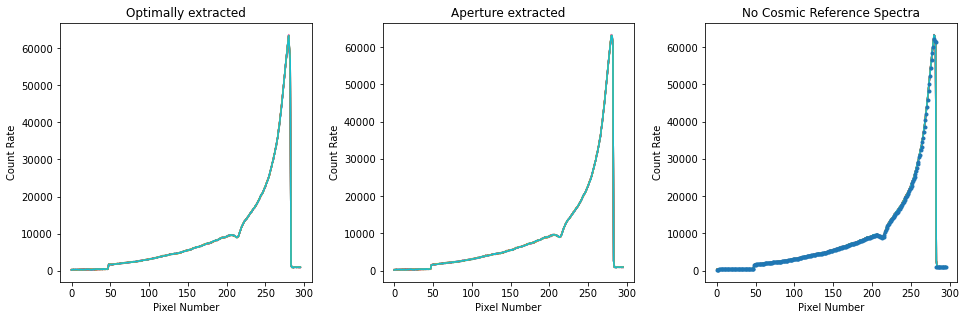

In [27]:
data_with_no_cosmics = spectral_image_cube_noc[valid_region_data]
data_illuminaton_model = illumination_model_image[valid_region_data[1:]]

data = spectral_image_cube[valid_region_data]
error = spectral_image_uncertainty[valid_region_data]
mask = new_bad_pixel_mask[valid_region_data]

cleaned_data = cleaned_image_cube[valid_region_data]
cleaned_data_error = cleaned_image_cube_uncertainty[valid_region_data]
cleaned_data_mask = cleaned_image_cube_mask[valid_region_data]

extraction_profile = filtered_image_cube[valid_region_data]
extraction_profile = extraction_profile/np.sum(extraction_profile, axis=2, keepdims=True)

optimally_extracted_spectra = \
    (np.ma.sum(~mask*extraction_profile*data*error**-2, axis=2) /
     np.ma.sum((~mask*extraction_profile/error)**2, axis=2))

aperture_extracted_spectrum = np.sum(cleaned_data * ~cleaned_data_mask, axis=2)

spectrum_with_no_cosmics = np.sum(data_with_no_cosmics, axis=2)
spectrum_illumination_model = np.sum(data_illuminaton_model[0, ...], axis=1)

fig, ax = plt.subplots(1,3, figsize=(14,5))
fig.tight_layout(pad=4.0)
ax[0].plot(optimally_extracted_spectra.T)
ax[0].set_title('Optimally extracted')
ax[0].set_ylabel('Count Rate')
ax[0].set_xlabel('Pixel Number')
ax[1].plot(aperture_extracted_spectrum.T)
ax[1].set_title('Aperture extracted')
ax[1].set_ylabel('Count Rate')
ax[1].set_xlabel('Pixel Number')
ax[2].plot(spectrum_with_no_cosmics.T)
ax[2].plot(spectrum_illumination_model,'.', lw=2)
ax[2].set_title('No Cosmic Reference Spectra')
ax[2].set_ylabel('Count Rate')
ax[2].set_xlabel('Pixel Number')
plt.show()

This concludes the introduction of the CASCADe-filtering package and it's use on MIRI LRS data. 